In [1]:
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import os
import cv2
from math import floor, ceil, pi

%matplotlib inline

## Collect image file paths

In [2]:
def get_image_paths():
    folder = './RawImages'
    files = os.listdir(folder)
    files.sort()
    files = ['{}/{}'.format(folder, file) for file in files]
    return files

In [3]:
X_img_paths = get_image_paths()
print(X_img_paths)

['./RawImages/01.png', './RawImages/02.png', './RawImages/03.png', './RawImages/04.png', './RawImages/05.png', './RawImages/06.png', './RawImages/07.png', './RawImages/08.png', './RawImages/09.png', './RawImages/10.png', './RawImages/11.png', './RawImages/12.png']


## Resize images to a common size

In [4]:
IMAGE_SIZE = 224

def tf_resize_images(X_img_file_paths):
    X_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, (None, None, 3))
    tf_img = tf.image.resize_images(X, (IMAGE_SIZE, IMAGE_SIZE), tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Each image is resized individually as different image may be of different size.
        for index, file_path in enumerate(X_img_file_paths):
            img = mpimg.imread(file_path)[:, :, :3] # Do not read alpha channel.
            resized_img = sess.run(tf_img, feed_dict = {X: img})
            X_data.append(resized_img)

    X_data = np.array(X_data, dtype = np.float32) # Convert to numpy
    return X_data

In [5]:
X_imgs = tf_resize_images(X_img_paths)
print(X_imgs.shape)

(12, 224, 224, 3)


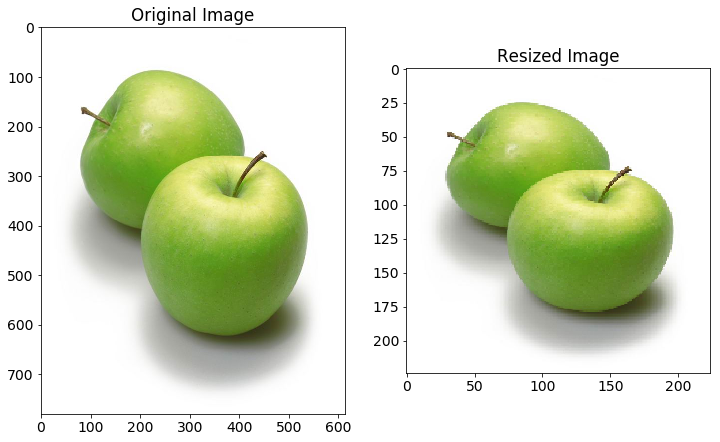

In [6]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(X_img_paths[0])[:,:,:3])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(X_imgs[0])
plt.title('Resized Image')
plt.show()

## Display all images

In [7]:
def display_all_images(X_imgs, n_cols = 4):
    n_rows = ceil(len(X_imgs) / n_cols)
    display_image = np.zeros([n_rows * IMAGE_SIZE, n_cols * IMAGE_SIZE, 3], dtype = np.float32)
    for i in range(n_rows):
        for j in range(n_cols):
            X_img = X_imgs[i * n_cols + j]
            disp_padded = np.pad(X_img, ((i * IMAGE_SIZE, (n_rows - 1 - i) * IMAGE_SIZE),
                                         (j * IMAGE_SIZE, (n_cols - 1 - j) * IMAGE_SIZE), (0, 0)), 'constant')
            display_image = np.add(display_image, disp_padded)

    plt.figure(figsize = (n_rows * 3, n_cols * 3))
    plt.imshow(display_image)
    plt.axis('off')
    plt.show()

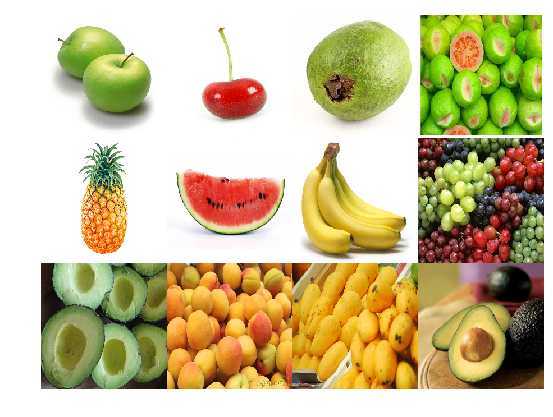

In [8]:
display_all_images(X_imgs)

# Image Augmentation Techniques:
## 1) Scaling

In [9]:
def central_scale_images(X_imgs, scales):
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((len(scales), 4), dtype = np.float32)
    for index, scale in enumerate(scales):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros((len(scales)), dtype = np.int32)
    crop_size = np.array([IMAGE_SIZE, IMAGE_SIZE], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, IMAGE_SIZE, IMAGE_SIZE, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data

In [10]:
# Produce each image at scaling of 90%, 75% and 60% of original image.
scaled_imgs = central_scale_images(X_imgs, [0.90, 0.75, 0.60])
print(scaled_imgs.shape)

(36, 224, 224, 3)


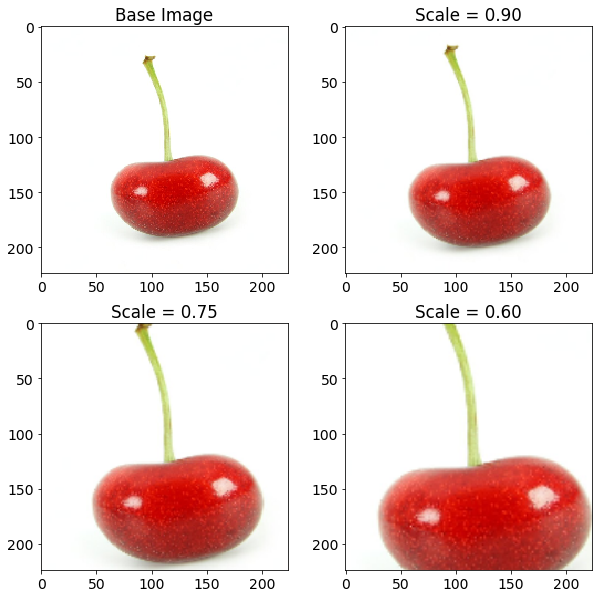

In [11]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[1])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(scaled_imgs[3])
plt.title('Scale = 0.90')
plt.subplot(2, 2, 3)
plt.imshow(scaled_imgs[4])
plt.title('Scale = 0.75')
plt.subplot(2, 2, 4)
plt.imshow(scaled_imgs[5])
plt.title('Scale = 0.60')
plt.show()

## 2) Translation

In [12]:
from math import ceil, floor

def get_translate_parameters(index):
    if index == 0: # Translate left 20 percent
        offset = np.array([0.0, 0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = 0
        w_end = int(ceil(0.8 * IMAGE_SIZE))
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 1: # Translate right 20 percent
        offset = np.array([0.0, -0.2], dtype = np.float32)
        size = np.array([IMAGE_SIZE, ceil(0.8 * IMAGE_SIZE)], dtype = np.int32)
        w_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = IMAGE_SIZE
    elif index == 2: # Translate top 20 percent
        offset = np.array([0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = 0
        h_end = int(ceil(0.8 * IMAGE_SIZE)) 
    else: # Translate bottom 20 percent
        offset = np.array([-0.2, 0.0], dtype = np.float32)
        size = np.array([ceil(0.8 * IMAGE_SIZE), IMAGE_SIZE], dtype = np.int32)
        w_start = 0
        w_end = IMAGE_SIZE
        h_start = int(floor((1 - 0.8) * IMAGE_SIZE))
        h_end = IMAGE_SIZE 
        
    return offset, size, w_start, w_end, h_start, h_end

def translate_images(X_imgs):
    offsets = np.zeros((len(X_imgs), 2), dtype = np.float32)
    n_translations = 4
    X_translated_arr = []
    
    tf.reset_default_graph()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(n_translations):
            X_translated = np.zeros((len(X_imgs), IMAGE_SIZE, IMAGE_SIZE, 3), dtype = np.float32)
            X_translated.fill(1.0) # Filling background color
            base_offset, size, w_start, w_end, h_start, h_end = get_translate_parameters(i)
            offsets[:, :] = base_offset 
            glimpses = tf.image.extract_glimpse(X_imgs, size, offsets)
            
            glimpses = sess.run(glimpses)
            X_translated[:, h_start: h_start + size[0], w_start: w_start + size[1], :] = glimpses
            X_translated_arr.extend(X_translated)
    X_translated_arr = np.array(X_translated_arr, dtype = np.float32)
    return X_translated_arr

In [13]:
translated_imgs = translate_images(X_imgs)
print(translated_imgs.shape)

(48, 224, 224, 3)


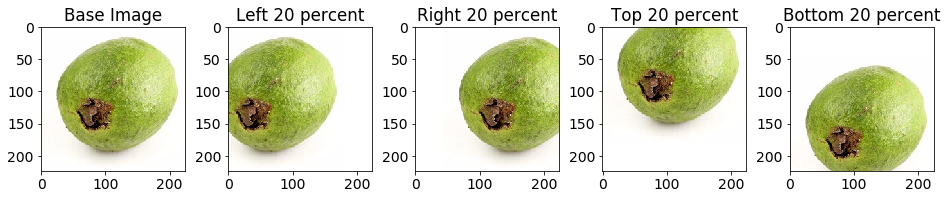

In [14]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[2])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[2])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[14])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[26])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[38])
plt.title('Bottom 20 percent')
plt.show()

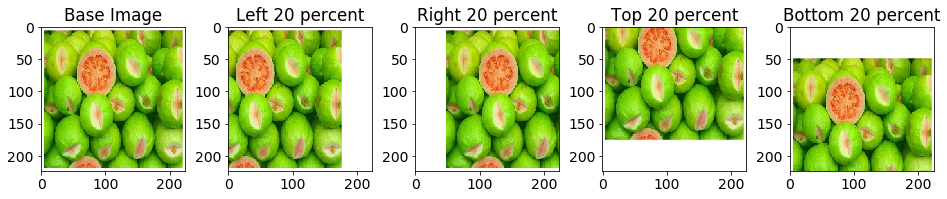

In [15]:
gs = gridspec.GridSpec(1, 5)
gs.update(wspace = 0.30, hspace = 2)

fig, ax = plt.subplots(figsize = (16, 16))
plt.subplot(gs[0])
plt.imshow(X_imgs[3])
plt.title('Base Image')
plt.subplot(gs[1])
plt.imshow(translated_imgs[3])
plt.title('Left 20 percent')
plt.subplot(gs[2])
plt.imshow(translated_imgs[15])
plt.title('Right 20 percent')
plt.subplot(gs[3])
plt.imshow(translated_imgs[27])
plt.title('Top 20 percent')
plt.subplot(gs[4])
plt.imshow(translated_imgs[39])
plt.title('Bottom 20 percent')
plt.show()

## 3) Rotation (at 90 degrees)

In [16]:
def rotate_images(X_imgs):
    X_rotate = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    k = tf.placeholder(tf.int32)
    tf_img = tf.image.rot90(X, k = k)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            for i in range(3):  # Rotation at 90, 180 and 270 degrees
                rotated_img = sess.run(tf_img, feed_dict = {X: img, k: i + 1})
                X_rotate.append(rotated_img)
        
    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate    

In [17]:
rotated_imgs = rotate_images(X_imgs)
print(rotated_imgs.shape)

(36, 224, 224, 3)


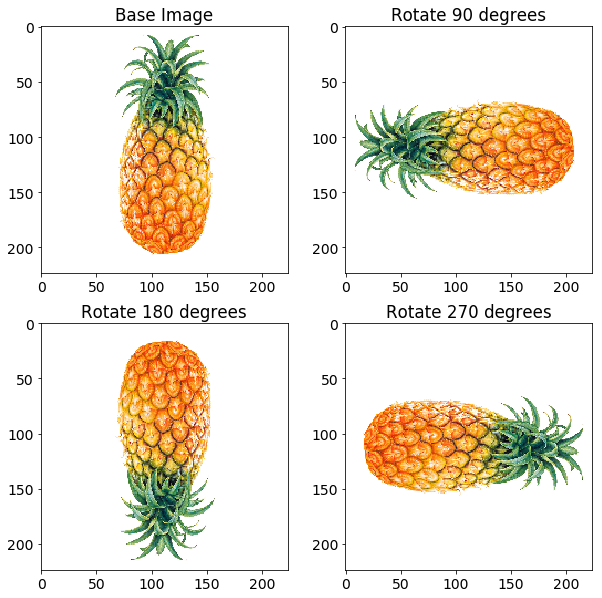

In [18]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[4])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(rotated_imgs[12])
plt.title('Rotate 90 degrees')
plt.subplot(2, 2, 3)
plt.imshow(rotated_imgs[13])
plt.title('Rotate 180 degrees')
plt.subplot(2, 2, 4)
plt.imshow(rotated_imgs[14])
plt.title('Rotate 270 degrees')
plt.show()

## 4) Rotation (at finer angles)

In [19]:
def rotate_images(X_imgs, start_angle, end_angle, n_images):
    X_rotate = []
    iterate_at = (end_angle - start_angle) / (n_images - 1)
    
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (None, IMAGE_SIZE, IMAGE_SIZE, 3))
    radian = tf.placeholder(tf.float32, shape = (len(X_imgs)))
    tf_img = tf.contrib.image.rotate(X, radian)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
    
        for index in range(n_images):
            degrees_angle = start_angle + index * iterate_at
            radian_value = degrees_angle * pi / 180  # Convert to radian
            radian_arr = [radian_value] * len(X_imgs)
            rotated_imgs = sess.run(tf_img, feed_dict = {X: X_imgs, radian: radian_arr})
            X_rotate.extend(rotated_imgs)

    X_rotate = np.array(X_rotate, dtype = np.float32)
    return X_rotate

In [20]:
# Start rotation at -90 degrees, end at 90 degrees and produce totally 14 images
rotated_imgs = rotate_images(X_imgs, -90, 90, 14)
print(rotated_imgs.shape)

(168, 224, 224, 3)


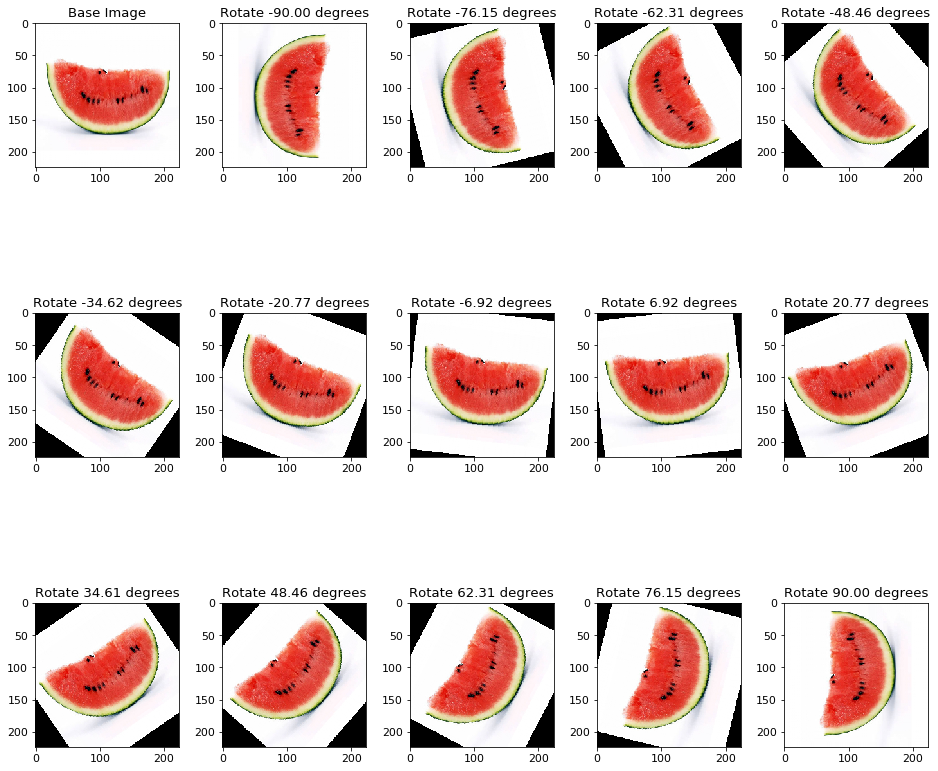

In [21]:
matplotlib.rcParams.update({'font.size': 11})

fig, ax = plt.subplots(figsize = (16, 16))
gs = gridspec.GridSpec(3, 5)
gs.update(wspace = 0.30, hspace = 0.0002)

plt.subplot(gs[0])
plt.imshow(X_imgs[5])
plt.title('Base Image')

for i in range(14):
    plt.subplot(gs[i + 1])
    plt.imshow(rotated_imgs[5 + 12 * i])
    plt.title('Rotate {:.2f} degrees'.format(-90 + 13.846 * i))
plt.show()

## 5) Flipping

In [22]:
def flip_images(X_imgs):
    X_flip = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 3))
    tf_img1 = tf.image.flip_left_right(X)
    tf_img2 = tf.image.flip_up_down(X)
    tf_img3 = tf.image.transpose_image(X)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for img in X_imgs:
            flipped_imgs = sess.run([tf_img1, tf_img2, tf_img3], feed_dict = {X: img})
            X_flip.extend(flipped_imgs)
    X_flip = np.array(X_flip, dtype = np.float32)
    return X_flip

In [23]:
flipped_images = flip_images(X_imgs)
print(flipped_images.shape)

(36, 224, 224, 3)


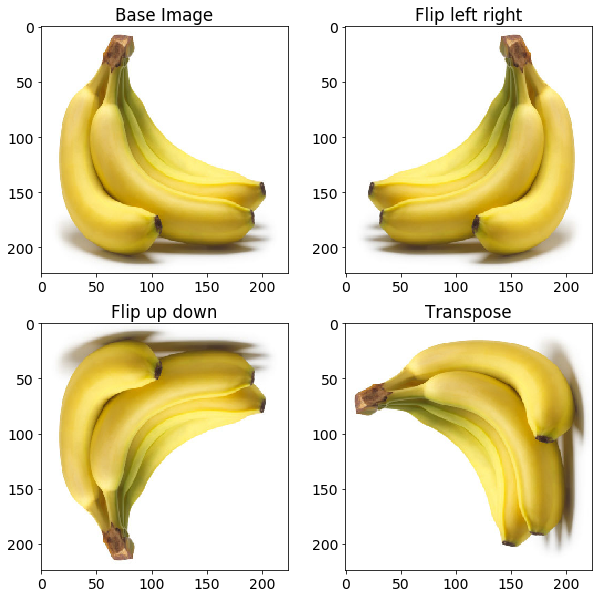

In [24]:
matplotlib.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[6])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(flipped_images[18])
plt.title('Flip left right')
plt.subplot(2, 2, 3)
plt.imshow(flipped_images[19])
plt.title('Flip up down')
plt.subplot(2, 2, 4)
plt.imshow(flipped_images[20])
plt.title('Transpose')
plt.show()

## 6) Adding Salt and Pepper Noise

In [25]:
def add_salt_pepper_noise(X_imgs):
    # Need to produce a copy as to not modify the original image
    X_imgs_copy = X_imgs.copy()
    row, col, _ = X_imgs_copy[0].shape
    salt_vs_pepper = 0.2
    amount = 0.004
    num_salt = np.ceil(amount * X_imgs_copy[0].size * salt_vs_pepper)
    num_pepper = np.ceil(amount * X_imgs_copy[0].size * (1.0 - salt_vs_pepper))
    
    for X_img in X_imgs_copy:
        # Add Salt noise
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 1

        # Add Pepper noise
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in X_img.shape]
        X_img[coords[0], coords[1], :] = 0
    return X_imgs_copy

In [26]:
salt_pepper_noise_imgs = add_salt_pepper_noise(X_imgs)
print(salt_pepper_noise_imgs.shape)

(12, 224, 224, 3)


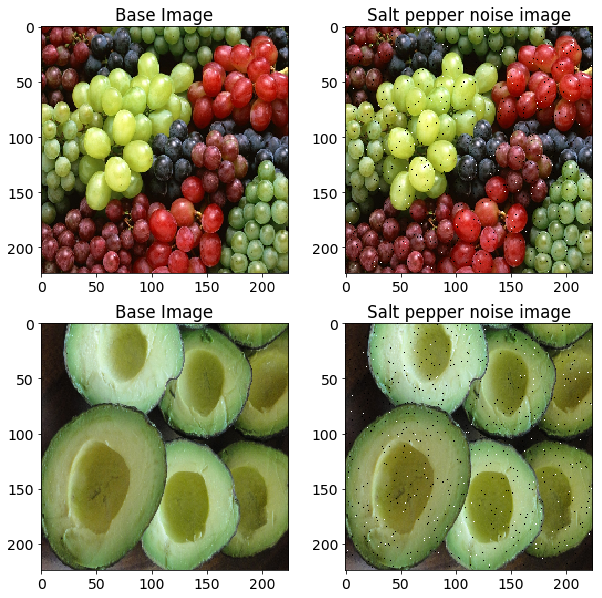

In [27]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[7])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_noise_imgs[7])
plt.title('Salt pepper noise image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[8])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(salt_pepper_noise_imgs[8])
plt.title('Salt pepper noise image')
plt.show()

## 7) Lighting Condition

In [28]:
def add_gaussian_noise(X_imgs):
    gaussian_noise_imgs = []
    row, col, _ = X_imgs[0].shape
    # Gaussian distribution parameters
    mean = 0
    var = 0.1
    sigma = var ** 0.5
    
    for X_img in X_imgs:
        gaussian = np.random.random((row, col, 1)).astype(np.float32)
        gaussian = np.concatenate((gaussian, gaussian, gaussian), axis = 2)
        gaussian_img = cv2.addWeighted(X_img, 0.75, 0.25 * gaussian, 0.25, 0)
        gaussian_noise_imgs.append(gaussian_img)
    gaussian_noise_imgs = np.array(gaussian_noise_imgs, dtype = np.float32)
    return gaussian_noise_imgs

In [29]:
gaussian_noise_imgs = add_gaussian_noise(X_imgs)
print(gaussian_noise_imgs.shape)

(12, 224, 224, 3)


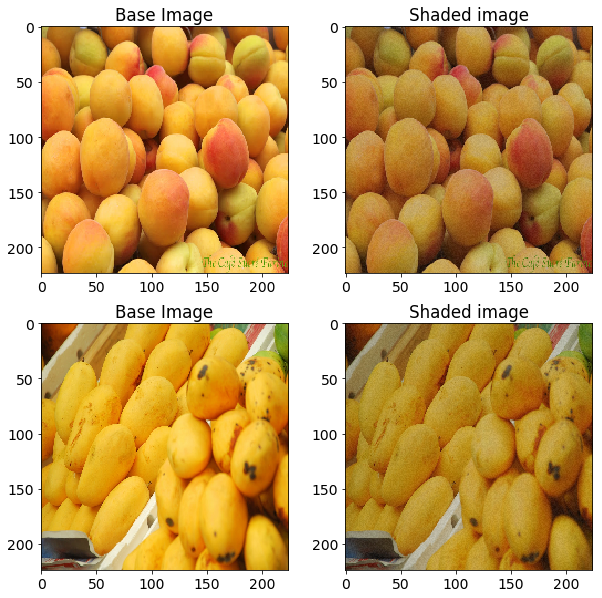

In [30]:
fig, ax = plt.subplots(figsize = (10, 10))
plt.subplot(2, 2, 1)
plt.imshow(X_imgs[9])
plt.title('Base Image')
plt.subplot(2, 2, 2)
plt.imshow(gaussian_noise_imgs[9])
plt.title('Shaded image')
plt.subplot(2, 2, 3)
plt.imshow(X_imgs[10])
plt.title('Base Image')
plt.subplot(2, 2, 4)
plt.imshow(gaussian_noise_imgs[10])
plt.title('Shaded image')
plt.show()

## 8) Perspective Transform

In [31]:
def get_mask_coord(imshape):
    vertices = np.array([[(0.09 * imshape[1], 0.99 * imshape[0]), 
                          (0.43 * imshape[1], 0.32 * imshape[0]), 
                          (0.56 * imshape[1], 0.32 * imshape[0]),
                          (0.85 * imshape[1], 0.99 * imshape[0])]], dtype = np.int32)
    return vertices

def get_perspective_matrices(X_img):
    offset = 15
    img_size = (X_img.shape[1], X_img.shape[0])

    # Estimate the coordinates of object of interest inside the image.
    src = np.float32(get_mask_coord(X_img.shape))
    dst = np.float32([[offset, img_size[1]], [offset, 0], [img_size[0] - offset, 0], 
                      [img_size[0] - offset, img_size[1]]])
    
    perspective_matrix = cv2.getPerspectiveTransform(src, dst)
    return perspective_matrix

def perspective_transform(X_img):
    # Doing only for one type of example
    perspective_matrix = get_perspective_matrices(X_img)
    warped_img = cv2.warpPerspective(X_img, perspective_matrix,
                                     (X_img.shape[1], X_img.shape[0]),
                                     flags = cv2.INTER_LINEAR)
    return warped_img

In [32]:
X_img = X_imgs[11]
perspective_img = perspective_transform(X_img)
print(perspective_img.shape)

(224, 224, 3)


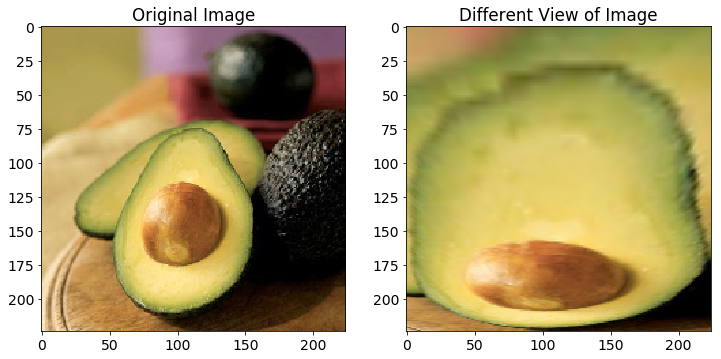

In [33]:
fig, ax = plt.subplots(figsize = (12, 12))
plt.subplot(1, 2, 1)
plt.imshow(X_imgs[11])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(perspective_img)
plt.title('Different View of Image')
plt.show()